# Algotrading prototyping notebook

### Important info

Alpha Vantage API key: DK3F3HB19R3IX4C3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# only run this cell if you want to (refresh) download new data
from alpha_vantage.foreignexchange import ForeignExchange
fx = ForeignExchange(key='YOUR_API_KEY', output_format='pandas')
eurusd, meta = fx.get_currency_exchange_daily(from_symbol='EUR', to_symbol='USD', outputsize='full')
eurusd.to_csv('/Users/danieltompkins/Documents/Algotrading_project/Data/EURUSD_180525.csv')

In [2]:
# Load the CSV into a DataFrame
eurusd = pd.read_csv('/Users/danieltompkins/Documents/Algotrading_project/Data/EURUSD_180525.csv', index_col=0, parse_dates=True)

# Optional: rename columns for simplicity
eurusd.columns = ['open', 'high', 'low', 'close']


# Optional: sort ascending (older dates first)
eurusd = eurusd.sort_index()

In [3]:
eurusd.head()

,open,high,low,close
date,,,,
2006-03-17,1.2182,1.2207,1.2139,1.2195
2006-03-20,1.2168,1.2196,1.2147,1.2165
2006-03-21,1.2154,1.2171,1.2074,1.2092
2006-03-22,1.2094,1.2114,1.2062,1.2074
2006-03-23,1.2075,1.2081,1.1953,1.1967


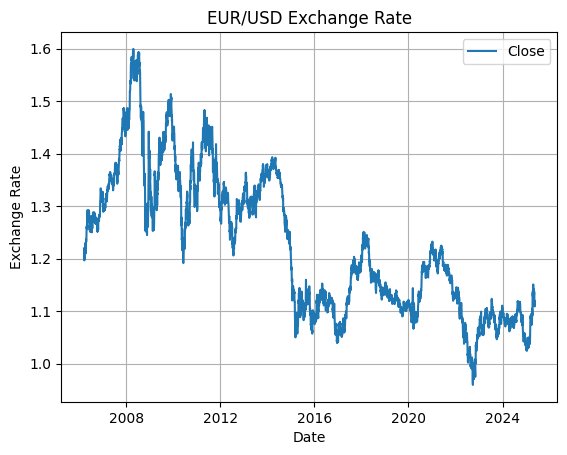

In [4]:
plt.plot(eurusd['close'], label='Close')
plt.title('EUR/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# create bollinger bands
window = 20
num_std = 2

def bollinger_bands(data, window=20, num_std_dev=2):
    rolling_mean = data['close'].rolling(window=window).mean()
    rolling_std = data['close'].rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    
    return rolling_mean, upper_band, lower_band

eurusd['sma'], eurusd['upper_band'], eurusd['lower_band'] = bollinger_bands(eurusd, window, num_std)

,open,high,low,close,upper_band,lower_band,sma
date,,,,,,,
2006-03-17,1.21820,1.22070,1.21390,1.21950,NaN,NaN,NaN
2006-03-20,1.21680,1.21960,1.21470,1.21650,NaN,NaN,NaN
2006-03-21,1.21540,1.21710,1.20740,1.20920,NaN,NaN,NaN
2006-03-22,1.20940,1.21140,1.20620,1.20740,NaN,NaN,NaN
2006-03-23,1.20750,1.20810,1.19530,1.19670,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-05-12,1.12136,1.12428,1.10651,1.10880,1.150532,1.115943,1.133238
2025-05-13,1.10878,1.11947,1.10868,1.11856,1.151144,1.114375,1.132759
2025-05-14,1.11855,1.12658,1.11643,1.11749,1.150929,1.112369,1.131649


In [33]:
# Step 1: Reset all signals
eurusd['signal'] = 0
eurusd['exit'] = 0
eurusd['position'] = 0  # Will be built iteratively

# Step 2: Entry conditions
buy_entry = eurusd['close'] < eurusd['lower_band']
sell_entry = eurusd['close'] > eurusd['upper_band']

# Step 3: Iterate through DataFrame to simulate real trading behavior
in_trade = 0  # 1 = long, -1 = short, 0 = flat
position = []

for i in range(len(eurusd)):
    price = eurusd['close'].iloc[i]
    sma = eurusd['sma'].iloc[i]

    # ENTRY LOGIC
    if in_trade == 0:
        if buy_entry.iloc[i]:
            eurusd.at[eurusd.index[i], 'signal'] = 1
            in_trade = 1
        elif sell_entry.iloc[i]:
            eurusd.at[eurusd.index[i], 'signal'] = -1
            in_trade = -1

    # EXIT LOGIC
    elif in_trade == 1 and price > sma and eurusd['close'].shift(1).iloc[i] <= eurusd['sma'].shift(1).iloc[i]:
        eurusd.at[eurusd.index[i], 'exit'] = 1
        in_trade = 0

    elif in_trade == -1 and price < sma and eurusd['close'].shift(1).iloc[i] >= eurusd['sma'].shift(1).iloc[i]:
        eurusd.at[eurusd.index[i], 'exit'] = 1
        in_trade = 0

    # Record position
    position.append(in_trade)

eurusd['position'] = position

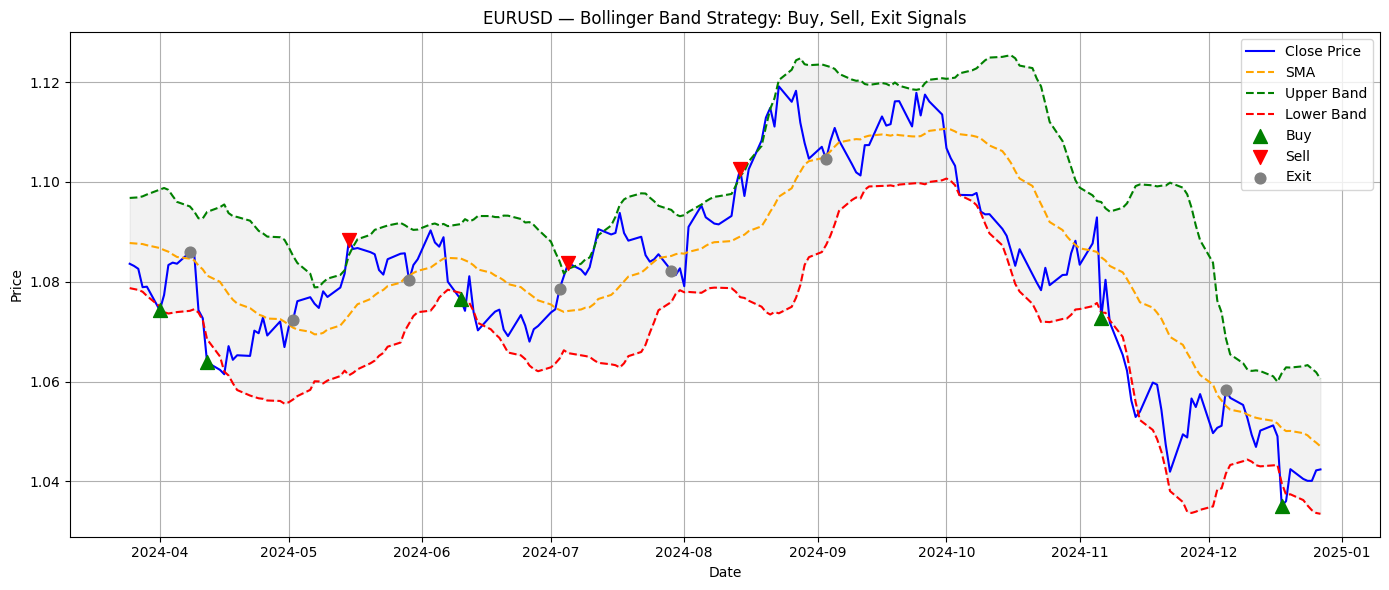

In [36]:
# Choose a date range — adjust as needed
subset = eurusd.iloc[-300:-100]  # 100 rows from a recent section

plt.figure(figsize=(14, 6))

# === Plot price and Bollinger Bands ===
plt.plot(subset.index, subset['close'], label='Close Price', color='blue', linewidth=1.5)
plt.plot(subset.index, subset['sma'], label='SMA', linestyle='--', color='orange')
plt.plot(subset.index, subset['upper_band'], label='Upper Band', linestyle='--', color='green')
plt.plot(subset.index, subset['lower_band'], label='Lower Band', linestyle='--', color='red')
plt.fill_between(subset.index, subset['lower_band'], subset['upper_band'], color='grey', alpha=0.1)

# === Plot Buy Signals ===
buy_signals = subset[subset['signal'] == 1]
plt.scatter(buy_signals.index, buy_signals['close'], label='Buy', marker='^', color='green', s=100, zorder=3)

# === Plot Sell Signals ===
sell_signals = subset[subset['signal'] == -1]
plt.scatter(sell_signals.index, sell_signals['close'], label='Sell', marker='v', color='red', s=100, zorder=3)

# === Plot Exit Signals ===
exit_signals = subset[subset['exit'] == 1]
plt.scatter(exit_signals.index, exit_signals['close'], label='Exit', marker='o', color='gray', s=60, zorder=3)

# === Formatting ===
plt.title('EURUSD — Bollinger Band Strategy: Buy, Sell, Exit Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
